In [151]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import documents as docs
import textcomparisons as tc
import random
import time

start = time.time()

data_folder = "data"
article_files = ["articles2019-06-01_" + str(i) + "-" + str(i + 5000) + ".csv" for i in range(0, 100000, 5000)]
article_files = article_files + ["articles2019-06-01_100000-100755.csv"]

def readArticles(path):
    """ Reads df of articles from the given path, and adds a column
    to store the Document-processed article """
    article_df = pd.read_csv(path)
    article_df["doc"] = None
    return article_df

# "login", 
keywords = ["subscription", "subscribe", "full access", "digital access", "sign up", "unlimited access", "unlimited digital access", "log in", "sign up"]
def keywordsin(str):
    for word in keywords:
        if word in str:
            return True
    return False

def isPaywall(i, to_doc = True):
    text = article_df.loc[i, "text"]
    text = text.lower()
    if len(text) < 500:
        article_df.loc[i, "paywall"] += 0.5
    if len(text) < 1000 and keywordsin(text):
        article_df.loc[i, "paywall"] += 1
    if to_doc and article_df.loc[i, "doc"] is None:
        article_df.loc[i, "doc"] = docs.Document(text, clean = False)
    return article_df.loc[i, "paywall"] > 0

def dict_by_ids(df, ids):
    """ Given a dataframe of articles and a list of article ids, 
    returns a dictionary with ids as keys and Documents as items, 
    computing and storing the Documents back in the df as needed
    """
    doc_dict = {}
    for doc_id in ids:
        row = df["id"] == doc_id
        doc = df.loc[row, "doc"].iloc[0]
        if doc is None:
            doc = docs.Document(df.loc[row, "text"].iloc[0], clean = False)
            df.loc[row, "doc"] = doc
        doc_dict[doc_id] = doc
    return doc_dict

def subsetmat(mat, inds):
    ''' Returns subset matrix of symmetric matrix mat, using inds
    '''
    subset = np.zeros((len(inds), len(inds)))
    for i in range(len(inds)):
        for j in range(len(inds)):
            subset[i, j] = mat[inds[i], inds[j]]
    return subset

try:
    article_df = pd.read_pickle("article_df_20190601")
except:
    article_df = [readArticles(os.path.join(data_folder, file)) for file in article_files]
    article_df = pd.concat(article_df)
    article_df = article_df.reset_index(drop = True)

    article_df["paywall"] = 0

events = [event for event in np.unique(article_df["event"]) if not np.isnan(event)]
n = [len(article_df.loc[article_df["event"] == event]) for event in events]
print("Event sizes: ", n)

try:
    results_df = pd.read_csv("results_20190601_clusters_temp.csv")
except: 
    results_df = pd.DataFrame(list(zip(events, n)), columns = ["event", "n"])
    results_df["unique25"] = np.nan
    results_df["unique75"] = np.nan
    results_df["n_good"] = np.nan
    results_df["unique25_good"] = np.nan
    results_df["unique75_good"] = np.nan

ac = tc.ArticleComparisons(thresh_jaccard = .5, thresh_same_sent = .9, thresh_same_doc = .25)
print("Setup time: %d seconds" % np.round(time.time() - start))

Event sizes:  [3175, 7333, 3280, 790, 750, 479, 1267, 2399, 269, 464, 187, 543, 580, 272, 1027, 377, 286, 391, 997, 269, 907, 272, 287, 351, 131, 333, 275, 503, 1067, 135, 691, 225, 123, 241, 263, 108, 140, 70, 239, 365, 172, 79, 244, 68, 68, 54, 69, 172, 172, 165]
Setup time: 11 seconds


In [152]:
i = 35
sample = np.array(article_df.loc[article_df["event"] == events[i], "id"])
article_dict = dict_by_ids(article_df, sample)
clustering = ac.cluster_articles(article_dict, plot = False)
good_inds = [i for i in range(len(sample)) if not isPaywall(sample[i])]
results_df.loc[i, "n_good"] = len(good_inds)
results_df.loc[i, "unique25"] = ac.prop_unique_clusters(thresh_same_doc = 0.25)
results_df.loc[i, "unique25_good"] = ac.prop_unique_clusters(thresh_same_doc = 0.25, inds = good_inds)
results_df.loc[i, "unique75"] = ac.prop_unique_clusters(thresh_same_doc = 0.75)
results_df.loc[i, "unique75_good"] = ac.prop_unique_clusters(thresh_same_doc = 0.75, inds = good_inds)
results_df.iloc[i, :]

0 / 108 done, 0.0 seconds elapsed
11 / 108 done, 1.11 seconds elapsed
22 / 108 done, 2.32 seconds elapsed
65 / 108 done, 5.71 seconds elapsed
76 / 108 done, 6.17 seconds elapsed


event             51.000000
n                108.000000
unique25           0.009259
unique75           0.009259
n_good            84.000000
unique25_good      0.011905
unique75_good      0.011905
Name: 35, dtype: float64

In [150]:
isPaywall(sample[1])

True

In [135]:
bad_ids = [i for i in sample if isPaywall(i)]
good_ids = [i for i in sample if i not in bad_ids]
for i in bad_ids:
    print(i, "\n", article_dict[i], "\n")
ac.prop_unique_clusters(inds = bad_inds)
# ac.display_mat(jsm_b, xlabs = bad_inds)

264 
 Settings 
 Welcome to E-Edition Plus. 
 The following pages are a new section of additional content not included in the newspaper, available exclusively to News+ Platinum members. 
 Already a member? Login or Activate your account. 
 You've reached the end of the standard E-Edition. 
 The following E-Edition Plus pages are a new section of additional content not included in the newspaper, available exclusively to News+ Platinum members. 
 Call 877-717-2565 to upgrade today. 
 Pages 

6724 
 Pick 4 Midday: 9-8-7-6 
 Welcome to E-Edition Plus. 
 The following pages are a new section of additional content not included in the newspaper, available exclusively to News+ Platinum members. 
 Already a member? Login or Activate your account. 
 You've reached the end of the standard E-Edition. 
 The following E-Edition Plus pages are a new section of additional content not included in the newspaper, available exclusively to News+ Platinum members. 
 Call 866-735-4407 to upgrade today. 

119

0.041666666666666664

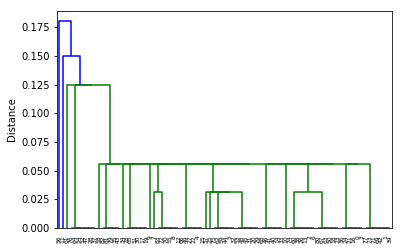

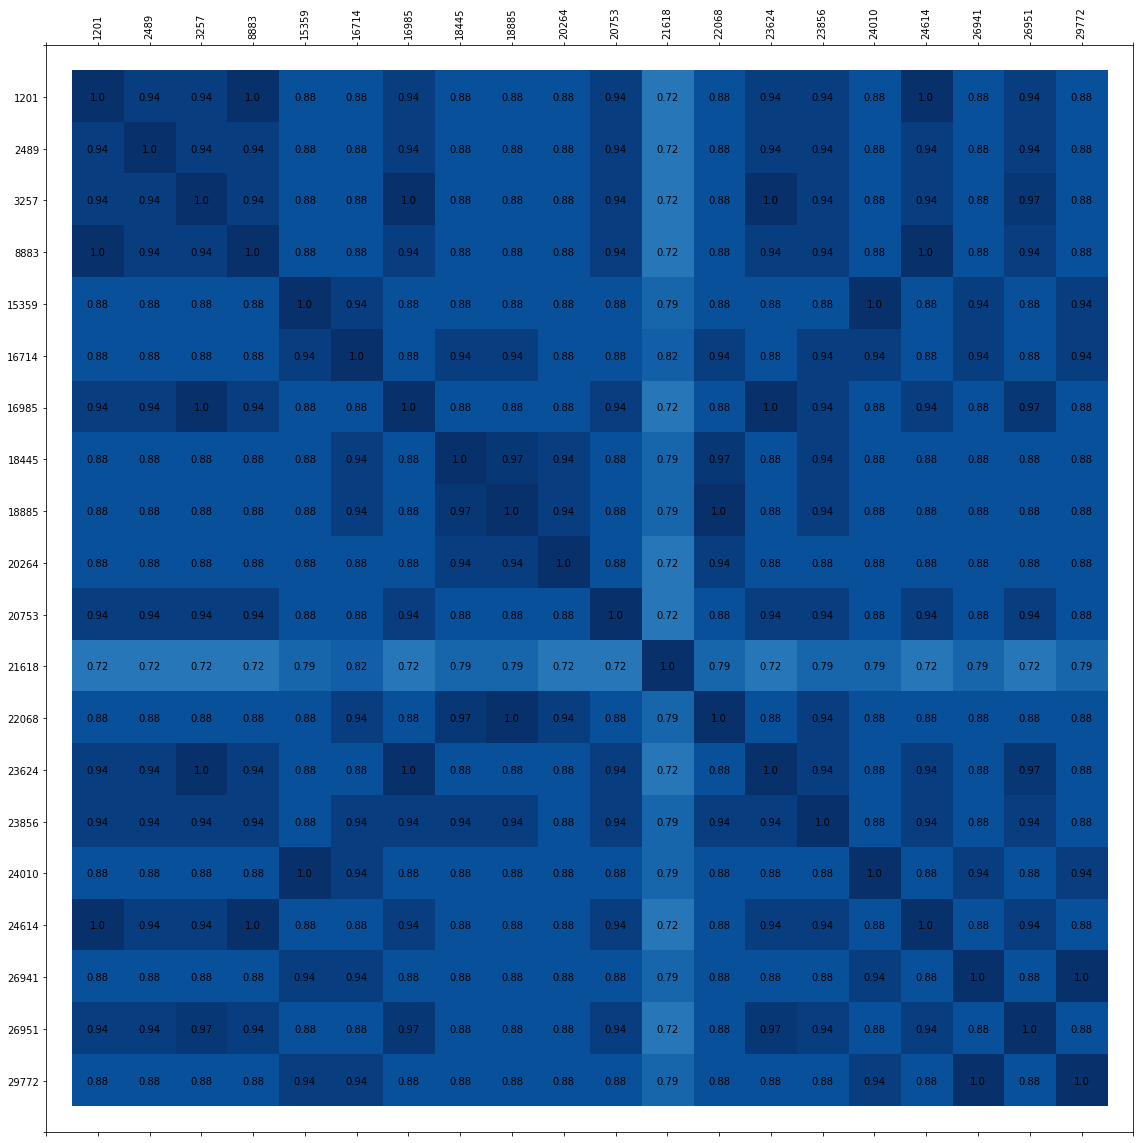

In [140]:
article_dict_good = dict_by_ids(article_df, good_ids)
jsm = ac.jac_score_mat(article_dict_good)
hc = ac.cluster_articles(plot = True)
# ac.display_mat(jsm, xlabs = list(article_dict.keys()))
n_subset = 20
ac.display_mat(subsetmat(jsm, list(range(n_subset))), xlabs = list(article_dict_good.keys())[0:n_subset])

Good articles: 1201 True 21618 True
S 0 : {{featured_button_text}} 
 Welcome to E-Edition Plus. 

	T 1 0.8 : Welcome to E-Edition Plus. 

S 1 : The following pages are a new section of additional content not included in the newspaper, available exclusively to News+ Platinum members. 

	T 2 1.0 : The following pages are a new section of additional content not included in the newspaper, available exclusively to News+ Platinum members. 

S 2 : Already a member? 

	T 3 1.0 : Already a member? 

S 3 : Login or Activate your account. 

	T 4 1.0 : Login or Activate your account. 

S 4 : You've reached the end of the standard E-Edition. 

	T 5 1.0 : You've reached the end of the standard E-Edition. 

S 5 : The following E-Edition Plus pages are a new section of additional content not included in the newspaper, available exclusively to News+ Platinum members. 

	T 6 1.0 : The following E-Edition Plus pages are a new section of additional content not included in the newspaper, available exclusiv

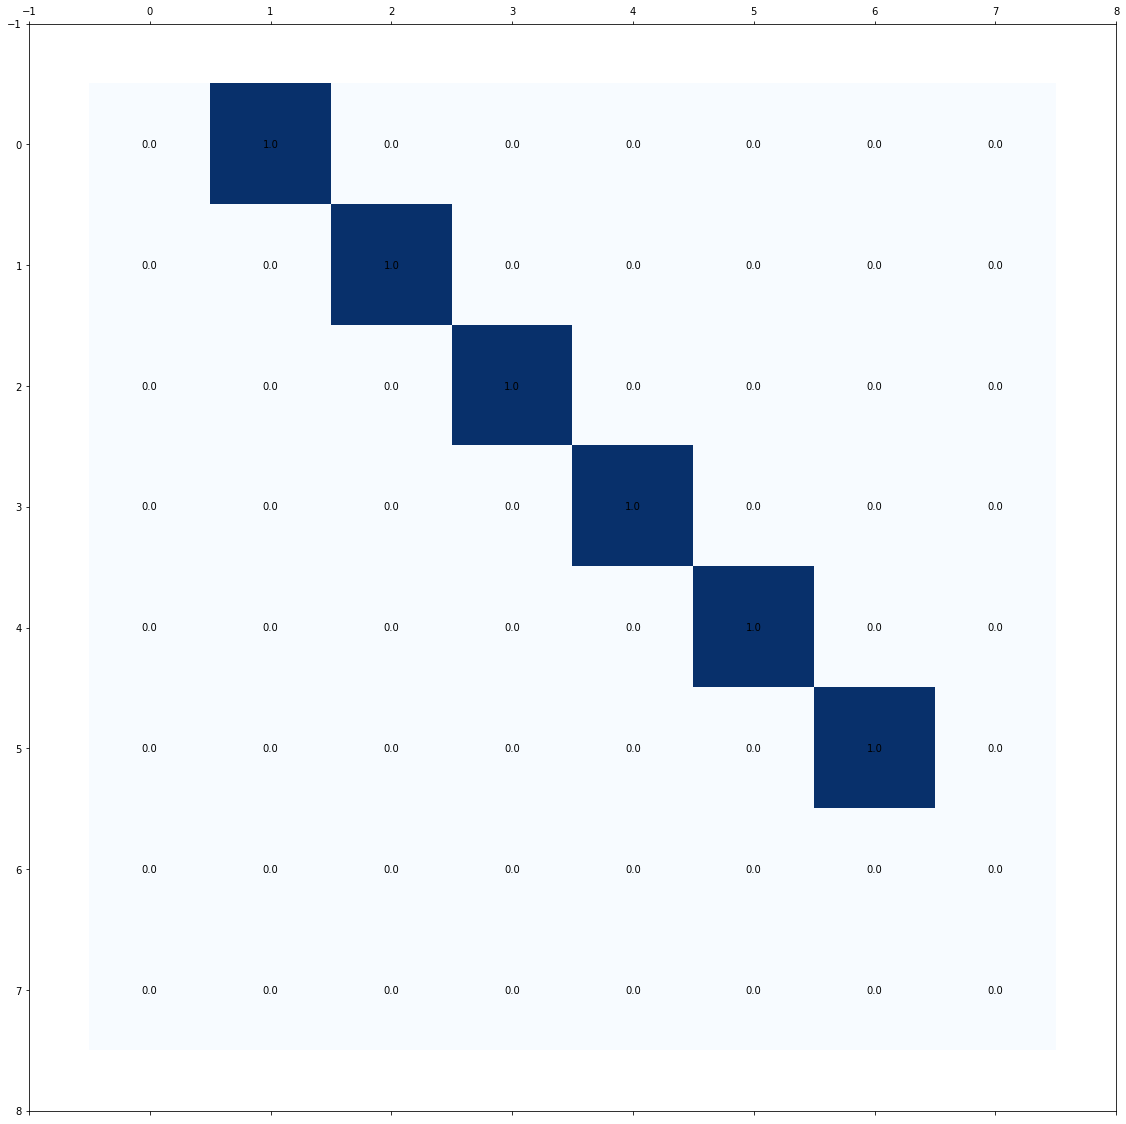

In [142]:
id1 = 1201
id2 = 21618
print("Good articles: %d" % id1, id1 in good_ids, id2, id2 in good_ids)
ac.display_mat(ac.get_match_matrix(article_dict[id1], article_dict[id2]))
ac.print_sentence_matches()

In [144]:
len(str(article_dict[id1]))

502

In [46]:
for doc in article_dict:
    print(doc, article_dict[doc])

223 Don't have an account? Sign Up Today 
 My Account 
 (59801) 
 Today 
 Partly cloudy skies. A stray shower or thunderstorm is possible. Low 52F. Winds WSW at 5 to 10 mph.. 
 Tonight 
 Partly cloudy skies. A stray shower or thunderstorm is possible. Low 52F. Winds WSW at 5 to 10 mph. 
 Updated: June 1, 2019 @ 3:15 pm 
 Email 
 Close 
 In this Friday, May 31, 2019, photo, Oriana Shulevitz Rosado, left, and Donna West watch as Democratic presidential candidate Sen. Elizabeth Warren, D-Mass., speaks via videoconference at West's home in Las Vegas. The chair of the Rural Nevada Democratic Caucus organized the virtual visit with groups around the state to ensure voters in sparsely-populated areas can play a role in vetting the party's crowded field of White House hopefuls. 
 John Locher 
 Democratic candidates cyber chat with rural Nevada voters 
 By MICHELLE L. PRICE Associated Press 
 Jun 1, 2019 
 {{featured_button_text}} 
 In this Friday, May 31, 2019, photo, Oriana Shulevitz Rosado, 

In [68]:
start = time.time()
tmp = pd.read_pickle("article_df_20190601")
print(time.time() - start)
# pickle: 3.31s, csv = 26s, picke = 12.7s

12.6980721950531


In [69]:
tmp

,id,publisher,scrape_time,on_homepage,url,title,text,fingerprint,event,doc,paywall
0,0,beforeitsnews.com,2019-06-01T04:51:24-04:00,True,https://beforeitsnews.com/v3/christian-news/20...,"47:2-3, 8-",First Option - Responsorial Psalm: Psalms 47:2...,"{'wordCounts': {'2': 1, '713350': 1, '14736': ...",NaN,None,0.0
1,1,thehindu.com,2019-06-01T08:44:25-04:00,True,https://www.thehindu.com/news/cities/Coimbator...,"In Gudalur, meat will come packed in Koova lea...","ePaper \n Just In \n In Gudalur, meat will com...","{'wordCounts': {'80836': 1, '3': 314, '11': 15...",NaN,None,0.0
2,2,cincinnati.com,2019-06-01T15:30:59-04:00,False,https://www.cincinnati.com/story/money/cars/20...,Trump's Mexico tariffs would hurt GM the most ...,FacebookEmail Twitter Google+ LinkedIn Pintere...,"{'wordCounts': {'17655': 1, '1999': 1, '3693':...",1.0,None,0.0
3,3,omaha.com,2019-06-01T05:32:26-04:00,False,https://www.omaha.com/obits/card-of-thanks/car...,Card of Thanks | Cards Of Thanks | omaha.com,Sign A Guestbook \n Offer a personal message o...,"{'wordCounts': {'209': 1, '34637': 1, '3': 46,...",NaN,None,0.0
4,4,techradar.com,2019-06-01T07:18:26-04:00,False,http://www.techradar.com/news/tottenham-vs-liv...,Tottenham vs Liverpool: live stream Champions...,Today's the day - all eyes on Madrid \n Shares...,"{'wordCounts': {'1422': 4, '80': 1, '627': 1, ...",19.0,None,0.0
5,5,reddit.com,2019-06-01T09:50:27-04:00,False,https://alb.reddit.com/c?q=CgADBkkuXIaFDuUKAAU...,NaN,"Indeed, over the last 2 years, I've interview...","{'wordCounts': {'571': 1, '1031': 1, '798': 4,...",NaN,None,0.0
6,6,goal.com,2019-06-01T15:45:33-04:00,False,https://www.goal.com/en-ng/news/i-love-you-so-...,Jose Antonio Reyes car crash: 'I love you so m...,Cesc Fabregas and Arsene Wenger have joined th...,"{'wordCounts': {'62125': 2, '62126': 2, '15359...",NaN,None,0.0
7,7,centurylink.net/news,2019-06-01T13:47:58-04:00,True,https://centurylink.net/news/read/category/new...,COMPUTEX 2019 Ended Successfully - news - Cent...,COMPUTEX 2019 Ended Successfully \n news now T...,"{'wordCounts': {'96060': 10, '1178': 8, '813':...",NaN,None,0.0
8,8,trib.com,2019-06-01T07:16:02-04:00,False,https://trib.com/business/investment/personal-...,Ask a Fool: How Will My Stocks Perform if the ...,Don't have an account? Sign Up Today \n My Acc...,"{'wordCounts': {'2962': 2, '209': 2, '3': 352,...",1.0,None,0.0
9,9,nj.com,2019-06-01T04:42:35-04:00,True,http://highschoolsports.nj.com/news/article/-1...,"Group track and field championships, 2019: Res...",NJ.com \n Enter City and State or Zip Code \n ...,"{'wordCounts': {'8567': 4, '3': 146, '137': 1,...",NaN,None,0.0
